# TD4: 2D Laplace equation

In this TD we want to solve the following [Dirichlet problem](https://en.wikipedia.org/wiki/Dirichlet_problem) on a bounded 2D spatial domain $\Omega$:
$$
    \begin{cases}
        \Delta f = 0 \text{ on } \Omega\\
        f = g \text{ on } \partial\Omega
    \end{cases}
$$
where $\partial\Omega$ is the frontier of the domain $\Omega$ and $g$ is a given function which determines the solution at the boundaries of the domain. From a physical point of view, the Laplace equation $\Delta f = 0$ is the steady-state heat equation, thus $f$ can be interpreted as a field of temperature and $g$ as the temperature imposed at the boundaries of the domain $\Omega$.

In the following we will work on a squared domain $\Omega = ]-\frac{L}{2}, \frac{L}{2}[^2$ and we will use a **finite-difference method** to solve this equation. We define a five-point stencil noted $\Delta_5$ and a nine-point stencil noted $\Delta_9$ as follows:
$$
\Delta_5 f (x, y) = \frac1{h^2}\left(f \left(x + h, y\right) + f \left(x - h, y\right) + f \left(x, y +h\right) + f\left(x, y -h\right) - 4f\left(x, y\right)\right)
$$
$$
\Delta_9 f (x, y) = \frac1{6h^2}\left(4\left(f \left(x + h, y\right) + f \left(x - h, y\right) + f \left(x, y +h\right) + f\left(x, y -h\right)\right) + f \left(x+h, y+h\right) + f \left(x-h, y+h\right) + f \left(x-h, y-h\right) + f \left(x+h, y-h\right) - 20f\left(x, y\right)\right)
$$
We can use these operators for a discrete function $f$ defined on a regular grid which discretizes the spatial domain $\Omega$. We just need to make sure that the $x$-discretization step is the same as the $y$-discretization step. These two operators can also be schematically represented by the two following arrays of coefficients:
$$
    \begin{array}{|c|c|c|}
    \hline
    &1&\\
    \hline
    1&-4&1\\
    \hline
    &1&\\
    \hline
    \end{array}
    \begin{array}{|c|c|c|}
    \hline
    1/6&2/3&1/6\\
    \hline
    2/3&-10/3&2/3\\
    \hline
    1/6&2/3&1/6\\
    \hline
    \end{array}
$$
Positions of the coefficients in the array refer to the neighbors of a given point in the grid. This given point is represented by the middle coefficient of the array.

To solve this kind of linear spatial problem we need to proceed in three steps:
1. Define a grid which covers $\Omega\cup\partial\Omega$ and is suitable for the chosen solving method.
2. Build the matrix which constrains the solution on the domain.
3. Find the inverse of this matrix to solve the problem.

We will need the following Python packages for this problem:

In [1]:
# To draw matplotlib plots within this notebook.
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la

**1)** Defining $h$ as the step of discretization along $x$ and $y$ axis, build a squared grid $\mathcal{G}$ which covers $\Omega\cup\partial\Omega$. We can use the [numpy meshgrid](https://docs.scipy.org/doc/numpy/reference/generated/numpy.meshgrid.html) function to get useful arrays of $x$ and $y$ coordinates.

In [2]:
L = 20
h = 0.2

x = np.arange(-L/2, L/2 + h, h)
y = np.arange(-L/2, L/2 + h, h)
xv, yv = np.meshgrid(x, y, sparse = True)
G = (xv, yv)

Defining $N$ as the number of points in the grid along $x$ or $y$ axis, now we need to impose $N\times N$ constraints on the numerical solution $f$. The linearity of the problem naturally leads to the definition of a matrix of constraints $A$.

With $(x_0, y_0)$ the bottom left corner of the grid $\mathcal{G}$, we should have:
$$
    \mathcal{G} = \{(x_i = x_0 + ih, y_j = y_0 + jh), i = 0, ..., N - 1 \text{ and } j = 0, ..., N-1\} 
$$

To solve our Dirichlet problem, let us approximate the laplacian operator $\Delta$ by the **five-point stencil** $\Delta_5$ previously defined. Now we want to find a solution $f$ defined on the grid $\mathcal{G}$ so that:
1. $\forall (x_i, y_j) \in \mathcal{G} \cap \Omega, \Delta_5 f(x_i, y_j) = 0$
2. $\forall (x_i, y_j) \in \mathcal{G} \backslash \Omega, f(x_i, y_j) = g(x_i, y_j)$
where $g$ is a given function.

We will store the values of the solution $f$ over the grid in a vector $X$ of length $N \times N$ where $X_{iN + j}$ coordinate will be the value of the solution $f$ at the grid point $(x_i, y_j)$.

**2)** Build a matrix $A$ of shape $(N \times N, N\times N)$ so that the previous constraints on the solution $f$ can be expressed as a linear problem:
$$
    AX = B
$$
with $B$ a vector of length $N \times N$ that only depends on $\{g(x_i, y_j)\}_{i,j}$ values. We can use in the following: $g(x,y) = \cos (2\pi(x + y)/L)$ to test our codes.

In [3]:
N = len(x)
    
def scord_to_index(cord, N, slen):
    return (cord[0] - slen//2)*N + (cord[1] - slen//2)
    
def build_A(N, stencil):
    A = np.zeros([N*N,N*N])
    for i in range(N):
        for j in range(N):
            k = i + N*j
            for scord, val in np.ndenumerate(stencil):
                try:
                    A[k, k + scord_to_index(scord, N, len(stencil))] = val
                except IndexError:
                    pass
                
    for j in range(N):
        A[j, :], A[N*(N-1) + j, :] = 0, 0
        A[j, j], A[N*(N-1) + j, N*(N-1) + j] = 1, 1
    for i in range(N):
        A[i*N, :], A[i*N + (N-1), :] = 0, 0
        A[i*N, i*N], A[i*N + (N-1), i*N + (N-1)] = 1, 1
    return A
            

def build_B(g, xv, yv, N):
    B = g(xv, yv)
    B[1:-1, 1:-1] = 0
    return np.reshape(B, (N*N, 1))

fiveStencil = [[0, 1, 0], [1, -4, 1], [0, 1, 0]]
A = build_A(N, fiveStencil)

B = build_B(lambda x, y : np.cos(2*np.pi*(x + y)/L), xv, yv, N)

**3)** Using [scipy.linalg.lu_factor](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu_factor.html) and [scipy.linalg.lu_solve](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu_solve.html) functions, solve the previous linear system through a LU decomposition of $A$. **Beware of the $\mathcal{O}(M^3)$ complexity of LU decomposition algorithm** where $M$ is the order of the input matrix (in our case, $M = N\times N$), computation time can be long!

In [4]:
lu, piv = la.lu_factor(A)
solution = la.lu_solve((lu, piv), B)

result = np.reshape(solution,(N,N))

**4)** Plot the solution of the Dirichlet problem on the domain $\Omega$. We may want to use [matplotlib.pyplot.pcolor](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.pcolor.html) function.

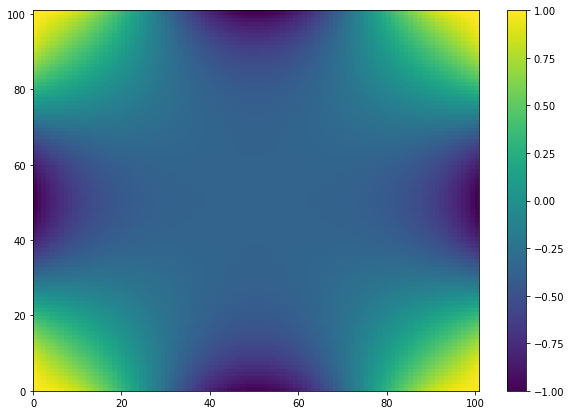

In [5]:
plt.figure(figsize = (10, 7))
plt.pcolor(result)
plt.colorbar()
plt.show()

**5)** Solve the same problem approximating the laplacian operator $\Delta$ with the **nine-point stencil** $\Delta_9$.

In [6]:
nineStencil = [[1/6, 2/3, 1/6], [2/3, -10/3, 2/3], [1/6, 2/3, 1/6]]
A = build_A(N, nineStencil)

B = build_B(lambda x, y : np.cos(2*np.pi*(x + y)/L), xv, yv, N)

In [7]:
lu, piv = la.lu_factor(A)
solution = la.lu_solve((lu, piv), B)

result = np.reshape(solution,(N,N))

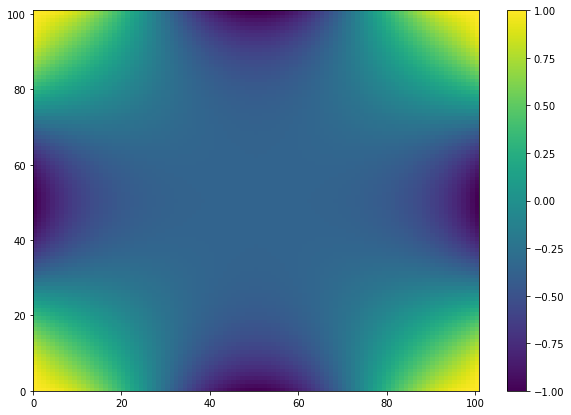

In [8]:
plt.figure(figsize = (10, 7))
plt.pcolor(result)
plt.colorbar()
plt.show()